# Digits Recognizer implementation from someone's notebook on Kaggle

This is a implementatio of some Kaggle user. This is just exercise for me in order to learn Data Science. 

## 1. Introduction
In the notebook is written that it is an implementation of five layers of Sequential Convolution Neural Network which is trained on the famous MNIST dataset. For implemntation is used keras API (tensorflow backend) which is very intuitive. Firstly I will prepare the data. In the next cell the imports are implemented

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import rmsprop_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

## 2. Data preparation

### 2.1 Load data

In [4]:
train = pd.read_csv("../../data/digits_rec/train.csv")
test = pd.read_csv("../../data/digits_rec/test.csv")

/home/tavchija/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

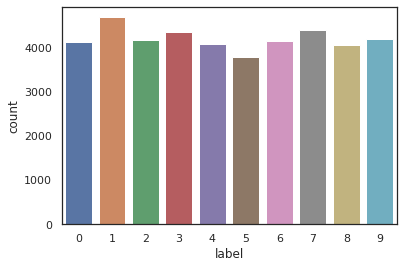

In [5]:
Y_train = train["label"]

# Drop 'label' column

X_train = train.drop(labels= ["label"], axis=1)

# free some space
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

## 2.2 Check for null and missing values

In [6]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 2.3 Reshape


In [9]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)



## 2.5 Label encoding

In [10]:
Y_train = to_categorical(Y_train, num_classes=10)

## 2.6 Split the train and the validation set for the fitting

In [15]:
random_seed = 2


X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, 
    Y_train, 
    test_size = 0.1, 
    random_state=random_seed)

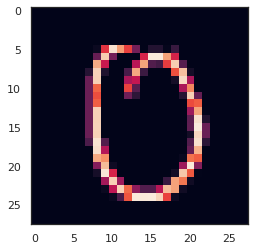

In [16]:
# Some examples
g = plt.imshow(X_train[0][:, :, 0])

# CNN
## 3.1 Define the model



In [18]:
model = Sequential()

model.add(
    Conv2D(
        filters = 32,
        kernel_size=(5,5),
        padding='Same',
        activation='relu',
        input_shape=(28, 28, 1)
    )
)

model.add(
    Conv2D(
        filters = 32,
        kernel_size=(5, 5),
        padding='Same',
        activation='relu'
    )
)

model.add(
    MaxPool2D(
        pool_size=(2, 2)
    )
)

model.add(Dropout(0.25))

model.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="Same",
        activation="relu"
    )
)

model.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="Same",
        activation='relu'
    )
)

model.add(
    MaxPool2D(
        pool_size=(2, 2),
        strides=(2, 2)
    )
)

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


## 3.2 Set the optimizer and annealer

In [22]:
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

epochs = 1
batch_size = 86



/home/tavchija/.local/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Data Augmentation

This is for enrichment the dataset

In [23]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
)

datagen.fit(X_train)

In [25]:
history = model.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=batch_size), 
    epochs=epochs,
    validation_data = (X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0],
    callbacks=[learning_rate_reduction]
)

/tmp/ipykernel_45065/3707748191.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


30618/30618 - 10s - loss: 0.4833 - accuracy: 0.8426 - val_loss: 0.0651 - val_accuracy: 0.9812 - lr: 0.0010 - 10s/epoch - 330us/step
